## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [ ] Separar um cojunto aleatório para teste
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e dp do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [ ] Calcular media e dp dos atrasos. 
- [ ] Normalizar os atrasos calculados (atraso - atraso_medio)/dp
- [x] Construir matriz de correlação de Pearson
- [ ] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas 
- [ ] Comparar pegando primeira UG e media por grupo



In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from itertools import combinations

In [2]:
def outliers(df:pd.DataFrame,cols : list):
    index_outliers =  []
    for col in cols:
        s = df[col]
        Q1 = s.quantile(0.1)
        Q3 = s.quantile(0.9)
        lower_bound =  Q1
        upper_bound =  Q3 
        index_outliers.extend(s.index[(s < lower_bound) | (s > upper_bound)])
    return set(index_outliers)

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [3]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [4]:
bd_combined[bd_combined.IdeUsinaOutorga==27339]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


In [5]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
bd_combined.loc[mask,"IdeUsinaOutorga"] = bd_combined.loc[mask,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
4377,38397,2023-12-01,2024-01-01,NaT,NaT,CE,25000.00,2023-02-01,NaT,NaT,...,None,NaT,NaT,2023-03-30,NaT,UFV,20,25000.00,skate,2021-03-16
4576,40885,2021-05-01,2021-05-07,2021-03-06,2021-04-09,CE,29400.00,2020-08-17,2020-05-15,2020-09-14,...,None,NaT,NaT,2019-06-01,2020-05-15,EOL,2,8400.00,skate,2019-07-02
5048,47179,2023-03-14,2023-05-14,NaT,NaT,BA,50400.00,2022-06-14,NaT,2022-07-14,...,None,NaT,NaT,2022-07-14,NaT,EOL,2,8400.00,skate,2021-12-07
2166,34372,2016-03-19,2016-03-20,2016-11-04,2016-11-08,AC,33.12,2015-12-05,NaT,NaT,...,None,NaT,NaT,2016-01-21,NaT,UTE,38,33.12,bdworgs,None
371,28975,2012-04-10,2012-04-30,2012-10-25,2012-12-29,SP,83.00,NaT,2011-12-30,NaT,...,None,NaT,NaT,NaT,NaT,UTE,1,33.00,bdworgs,None
5002,46883,2023-04-20,2023-05-30,NaT,NaT,BA,48000.00,2022-08-01,NaT,NaT,...,None,NaT,NaT,2022-12-15,NaT,UFV,24,48000.00,skate,2021-10-05
221,28446,NaT,2004-06-02,2011-02-05,2011-02-25,TO,11.40,2002-08-14,2006-09-01,NaT,...,None,2004-03-15,NaT,NaT,NaT,PCH,1,11.40,bdworgs,None
880,30283,2012-05-01,NaT,2012-06-16,2012-07-01,BA,35.07,2010-10-01,2010-10-18,2011-03-01,...,2011-05-01,NaT,NaT,NaT,NaT,EOL,1,35.07,bdworgs,None
5420,49204,2024-12-01,2025-01-01,NaT,NaT,MG,44100.00,2024-03-01,NaT,NaT,...,None,NaT,NaT,2024-05-01,NaT,UFV,29,44100.01,skate,2022-03-08


In [6]:
bd_combined[bd_combined.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [7]:
bd_combined = bd_combined[bd_combined.DatUGInicioOpComerOutorgado.notna()
                            & bd_combined.DatLiberOpComerRealizado.notna()].copy(deep=True)

In [8]:
bd_combined[bd_combined.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


In [10]:
nomes_tempo_construcao = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
} 

tempo_construcao_por_UG = bd_combined[["IdeUsinaOutorga","SigTipoGeracao"]].copy(deep=True)
for nome,marco in nomes_tempo_construcao.items():
    tempo_construcao_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_construcao_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"] 
tempo_construcao_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
5,42_2,UHE,1615 days,NaT,NaT,24 days,0 days
6,127,UTE,561 days,NaT,NaT,NaT,15 days
7,161,PCH,1163 days,677 days,NaT,38 days,2290 days
9,291,PCH,697 days,419 days,NaT,45 days,1676 days


In [11]:
is_first = True 
combinacoes = list(combinations([x for x in tempo_construcao_por_UG.columns if x not in ["IdeUsinaOutorga","SigTipoGeracao","Atraso"]],2))
#combinacoes = list(combinations(["IO","CC","ME","MT","OT"],2))

for p_marco, s_marco in combinacoes:
    idx_loop =  ((tempo_construcao_por_UG[p_marco] >= tempo_construcao_por_UG[s_marco]) | 
                 tempo_construcao_por_UG[p_marco].isna() | 
                 tempo_construcao_por_UG[s_marco].isna())

    idx = idx_loop if is_first else (idx & idx_loop)
    is_first = False 

#idx_usinas = idx & (tempo_construcao_por_UG.IO_OC.notna())
tempo_construcao_por_UG_filtered = tempo_construcao_por_UG[idx].copy(deep=True)
tempo_construcao_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...
5752,50872,UTE,98 days,NaT,98 days,41 days,-920 days
5776,51444,UTE,99 days,NaT,99 days,22 days,-385 days
5782,51450,UTE,104 days,NaT,104 days,26 days,-380 days


In [13]:
tempo_construcao_por_UG[~idx]

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
96,27339,UTE,-8354 days,NaT,NaT,0 days,0 days
223,28462,UTE,-1560 days,NaT,NaT,71 days,180 days
292,28780,PCH,885 days,454 days,546 days,79 days,349 days
293,28780,PCH,885 days,454 days,546 days,79 days,318 days
448,29122,UTE,-202 days,NaT,NaT,31 days,-1101 days
...,...,...,...,...,...,...,...
4557,40879,EOL,533 days,340 days,121 days,144 days,145 days
4569,40884,EOL,207 days,293 days,141 days,27 days,16 days
4570,40884,EOL,221 days,307 days,155 days,41 days,30 days


In [14]:
idx_primeira_ug =  bd_combined[idx].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
bd_combined_usinas.sample(10)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
262,28708,2005-07-22,2005-09-01,2007-08-22,2007-11-13,AL,27.40,2005-03-01,2005-03-15,NaT,...,None,NaT,NaT,NaT,NaT,UTE,1,15.00,bdworgs,None
1612,31606,2017-10-13,2017-12-01,2019-06-20,2019-11-14,BA,16.00,2016-02-28,2015-08-04,2016-05-31,...,2019-01-18,NaT,NaT,2016-08-31,2015-06-15,EOL,8,16.00,bdworgs,None
2244,35567,NaT,2020-07-03,2018-01-19,2018-01-24,MG,8.95,NaT,2016-01-01,NaT,...,None,NaT,NaT,NaT,NaT,UTE,1,8.95,bdworgs,None
4036,37723,2018-11-09,2018-11-20,2019-08-31,2020-01-28,AM,10127.00,2018-06-24,2018-07-15,NaT,...,None,NaT,NaT,NaT,2019-05-30,UTE,16,10127.00,skate,2017-07-25
4872,45074,2020-08-10,2022-09-18,2020-08-11,2020-09-01,MT,22360.00,2019-08-10,2019-12-10,NaT,...,None,NaT,NaT,2019-10-10,2020-04-15,UTE,1,22360.00,skate,2019-09-10
1044,30477,2013-06-29,2015-01-01,2014-12-23,2015-01-15,RS,20.00,2011-10-01,2012-09-01,2012-03-01,...,2013-03-01,NaT,NaT,2012-03-01,2012-08-01,EOL,10,20.00,bdworgs,None
2921,33006,2022-11-17,2023-01-01,2020-07-14,2020-11-12,PI,31500.00,2022-03-15,2019-06-15,2022-05-01,...,None,NaT,NaT,2022-04-01,2019-05-06,EOL,3,9450.00,skate,2018-06-11
1595,31579,2017-12-27,2018-01-01,2018-04-06,2018-05-18,CE,21.00,2017-03-17,2017-01-15,2017-06-27,...,2017-09-14,NaT,NaT,2017-04-30,2017-04-08,EOL,10,21.00,bdworgs,None
2240,35527,NaT,2019-08-08,2017-07-20,2017-08-18,GO,8.50,NaT,2016-03-30,NaT,...,None,NaT,NaT,NaT,2016-10-30,UTE,1,8.50,bdworgs,None


In [15]:
# Atrasos por usinas são calculados com base UG com menor atraso.
tempo_construcao_por_usina = tempo_construcao_por_UG_filtered.loc[idx_primeira_ug,:]
#tempo_construcao_por_usina.set_index(keys = "IdeUsinaOutorga",inplace=True)
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...
5752,50872,UTE,98 days,NaT,98 days,41 days,-920 days
5776,51444,UTE,99 days,NaT,99 days,22 days,-385 days
5782,51450,UTE,104 days,NaT,104 days,26 days,-380 days


In [16]:
# Cria tabela para calculos por geracao
tempo_construcao_por_geracao = pd.DataFrame()
tempo_construcao_por_geracao["SigTipoGeracao"] = bd_combined.SigTipoGeracao.unique() 


# Realiza calculos por geracao
for coluna in tempo_construcao_por_usina.columns:
    if coluna not in ["IdeUsinaOutorga","SigTipoGeracao"]:
        tempo_construcao_por_geracao[f"{coluna}_media"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].mean())
        #tempo_construcao_por_geracao[f"{coluna}_std"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].std())

tempo_construcao_por_geracao.set_index("SigTipoGeracao",inplace=True)
display(tempo_construcao_por_geracao)

,IO_OC_media,CC_OC_media,ME_OC_media,OT_OC_media,Atraso_media
SigTipoGeracao,,,,,
UHE,1845 days 12:18:46.956521728,1621 days 03:27:45.671641792,1516 days 07:42:13.333333328,50 days 23:23:04.615384615,204 days 04:02:01.008403362
UTE,686 days 03:32:05.581395352,NaT,518 days 12:51:14.157303368,104 days 17:30:13.533834586,296 days 15:39:25.714285716
PCH,876 days 02:01:03.716814160,644 days 20:41:08.571428568,402 days 15:49:56.858638744,50 days 12:36:08.339768340,993 days 17:03:00.694980688
CGH,895 days 13:55:12,666 days 22:28:05.106382976,480 days 01:12:00,103 days 00:48:48.813559322,415 days 05:36:00
EOL,561 days 17:28:45.746799432,493 days 03:34:14.935622320,357 days 22:04:08.275862068,58 days 14:10:04.267425320,66 days 12:15:21.763869132
UFV,376 days 21:46:29.403973508,NaT,244 days 08:09:36,70 days 22:24:38.145695364,-5 days +20:20:39.735099338


In [17]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga"]]
def id_marco(ID,nome,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for nome,marco in nomes_tempo_construcao.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,nome,marco))

In [18]:
marco_medio_usina

,IdeUsinaOutorga,DatInicioObraRealizado_estimado,DatConcretagemRealizado_estimado,DatMontagemRealizado_estimado,DatLiberacaoSFGTeste_estimado
idx,,,,,
0,12_0,2002-02-09 11:41:13.043478272,2002-09-21 20:32:14.328358208,2003-01-04 16:17:46.666666672,2007-01-09 00:36:55.384615385
1,12_1,2003-08-13 11:41:13.043478272,2004-03-24 20:32:14.328358208,2004-07-07 16:17:46.666666672,2008-07-12 00:36:55.384615385
2,19,2000-02-14 20:27:54.418604648,NaT,2000-07-31 11:08:45.842696632,2001-09-18 06:29:46.466165414
3,42_0,1998-11-10 11:41:13.043478272,1999-06-22 20:32:14.328358208,1999-10-05 16:17:46.666666672,2003-10-10 00:36:55.384615385
4,42_1,2000-08-11 11:41:13.043478272,2001-03-23 20:32:14.328358208,2001-07-06 16:17:46.666666672,2005-07-11 00:36:55.384615385
...,...,...,...,...,...
5752,50872,2022-07-10 20:27:54.418604648,NaT,2022-12-25 11:08:45.842696632,2024-02-12 06:29:46.466165414
5776,51444,2021-05-14 20:27:54.418604648,NaT,2021-10-29 11:08:45.842696632,2022-12-17 06:29:46.466165414
5782,51450,2021-05-14 20:27:54.418604648,NaT,2021-10-29 11:08:45.842696632,2022-12-17 06:29:46.466165414


In [19]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in nomes_tempo_construcao.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

In [20]:
atraso_usina.sample(10)

,IdeUsinaOutorga,SigTipoGeracao,Atraso,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
idx,,,,,,,
1869,32345,EOL,193 days,116 days 17:28:45.746799432,291 days 03:34:14.935622320,NaT,119 days 14:10:04.267425320
1883,32352,EOL,67 days,302 days 17:28:45.746799432,324 days 03:34:14.935622320,NaT,20 days 14:10:04.267425320
259,28696,UTE,737 days,608 days 03:32:05.581395352,NaT,532 days 12:51:14.157303368,NaT
151,28047,UTE,731 days,854 days 03:32:05.581395352,NaT,NaT,727 days 17:30:13.533834586
4000,37687,UTE,242 days,398 days 03:32:05.581395352,NaT,536 days 12:51:14.157303368,277 days 17:30:13.533834586
1929,32526,EOL,-55 days,149 days 17:28:45.746799432,140 days 03:34:14.935622320,NaT,-69 days +14:10:04.267425320
842,30168,UTE,297 days,66 days 03:32:05.581395352,NaT,NaT,285 days 17:30:13.533834586
3442,35109,UTE,193 days,167 days 03:32:05.581395352,NaT,221 days 12:51:14.157303368,256 days 17:30:13.533834586
717,29736_9,UHE,521 days,476 days 12:18:46.956521728,283 days 03:27:45.671641792,268 days 07:42:13.333333328,524 days 23:23:04.615384615


Não foi possível calcular: DatConcretagemRealizado_atraso para UTE
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,56.6%,63.1%,35.7%,99.3%
UTE,54.3%,-,51.6%,97.4%
PCH,87.8%,89.4%,95.7%,97.7%
CGH,55.6%,72.4%,81.9%,98.8%
EOL,77.2%,77.0%,80.4%,99.7%
UFV,92.7%,-,93.4%,98.0%


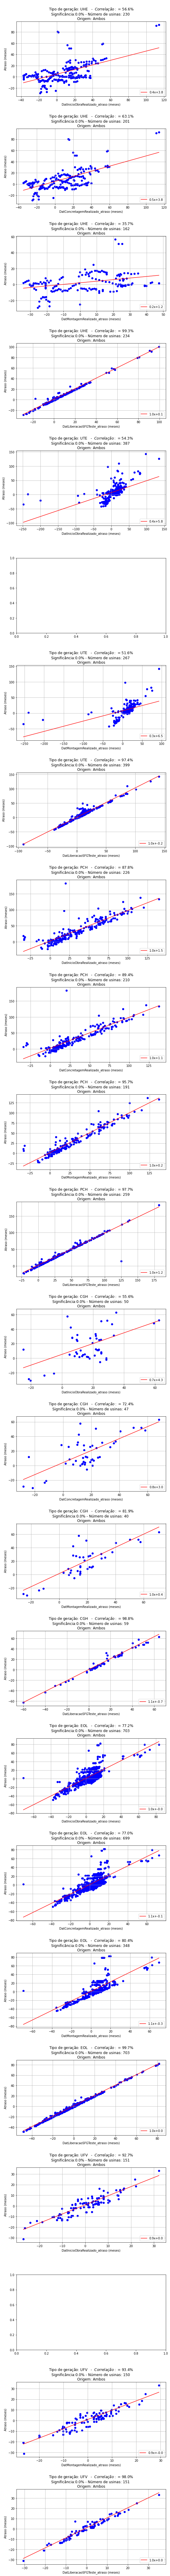

In [21]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]
tipos_geracao = tempo_construcao_por_geracao.index.to_list()
matrix_pearson = {}

for k,origem in enumerate(analises_origem):
    
    if not plot_created:    
        num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
        fig, axes = plt.subplots(num_subplots,len(analises_origem),figsize=(len(analises_origem)*8,num_subplots*5))
        plot_created =True
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        for nome_coluna in nomes_colunas_atrasos:
            count+=1
            try:
                ordered_notna = atraso_usina[(atraso_usina[nome_coluna].notna())
                                                 & (atraso_usina.SigTipoGeracao == SigTipoGeracao) ].sort_values(by = nome_coluna)
                x = ordered_notna[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                res = stats.linregress(x.flatten(), y.flatten())
                a, b, r, p_value, std_err = res
                r_str = f"{100*r:.1f}%"
                matrix_pearson[SigTipoGeracao].append(r_str)
                p_value_str = f"{100*p_value:.1f}%"
                ax = axes[count]
                ax.scatter(x,y,color="blue")
                ax.set_xlabel(f"{nome_coluna} (meses)")
                ax.set_ylabel(f"Atraso (meses)")
                ax.plot(x,a*x+b+1,color="red",label= f"{a:.1f}x+{b:.1f}")
                ax.set_title(f"\nTipo de geração: {SigTipoGeracao}   -  $Correlação:$ = {r_str}\nSignificância:{p_value_str} - Número de usinas: {x.shape[0]} \nOrigem: {origem}")
                ax.legend(loc="lower right")
                ax.grid()
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}")
                matrix_pearson[SigTipoGeracao].append("-")
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)